In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm
import datasets

### forward

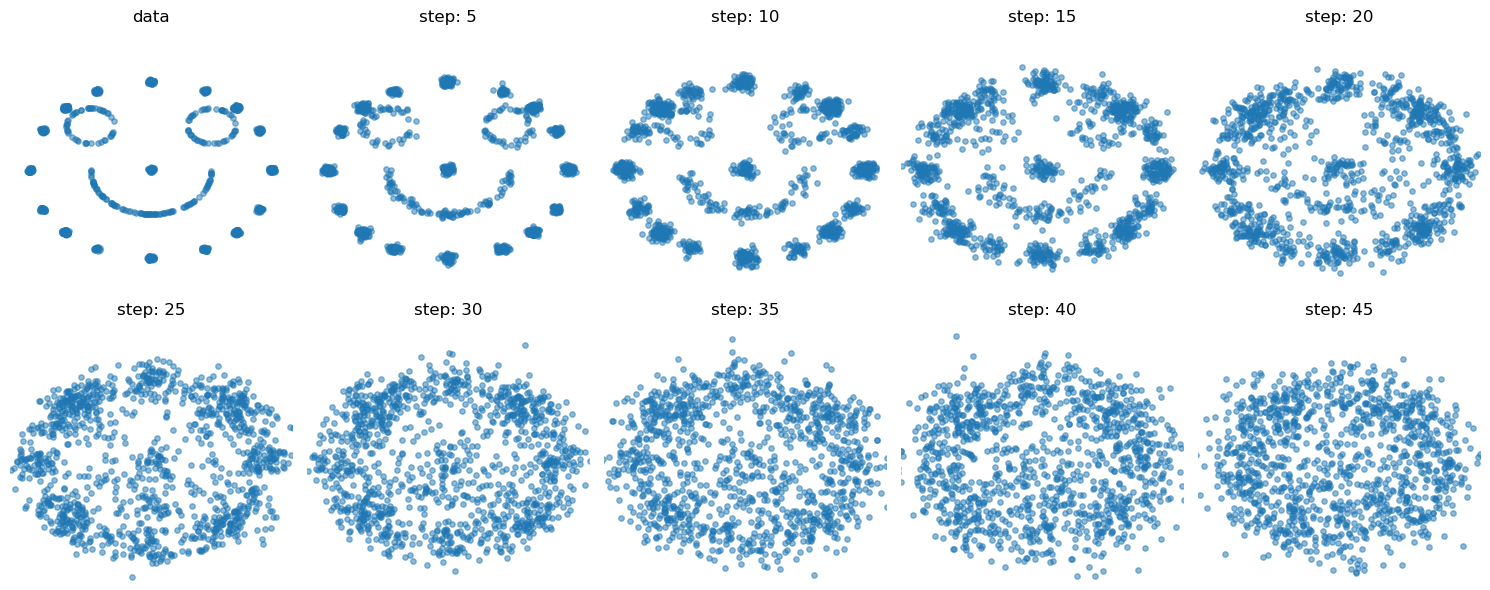

In [25]:
num_timesteps = 50
plot_step = 5

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
dataset = datasets.get_dataset("circle", n=1000)
x0 = dataset.tensors[0]

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
        
fig.tight_layout()
plt.savefig("static/forward.png", facecolor="white")
plt.show()

### reverse

In [26]:
!python ddpm.py --experiment_name smiley --dataset circle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Training model...
100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 169.86it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [30]:
model = ddpm.MLP()

path = "exps/dino_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp1): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp2): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [31]:
eval_batch_size = 1000
num_timesteps = 50
plot_step = 5
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)
    

100%|██████████| 50/50 [00:00<00:00, 169.07it/s]


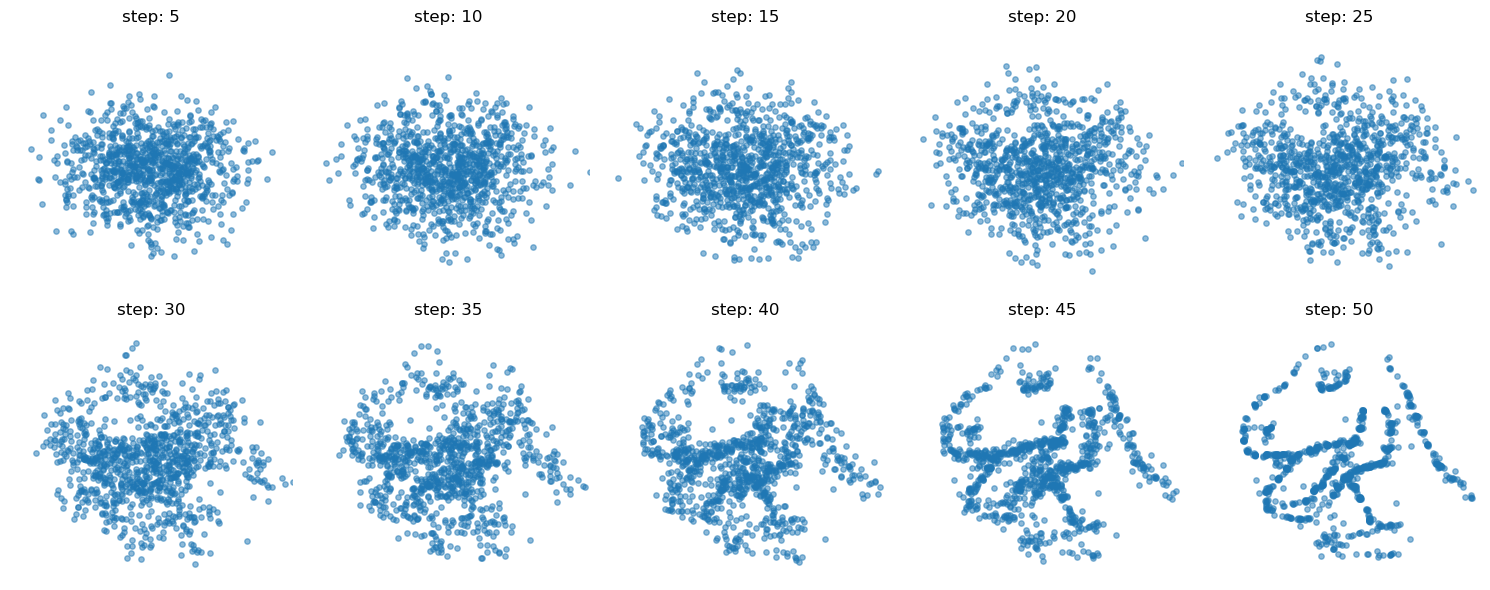

In [32]:
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
plt.savefig("static/reverse.png", facecolor="white")
plt.show()

## ablations

In [15]:
def plot_ablation(frames_dict, outname):
    num_rows = len(frames_dict)
    num_cols = 10

    fig = plt.figure(figsize=(3.5*num_cols, 3*num_rows + 0.5))
    row = 0

    for name, frames in frames_dict.items():
        epoch_step = len(frames) // num_cols
        offset = row*(num_cols + 1)
        plt.subplot(num_rows, num_cols + 1, offset + 1)
        plt.scatter(0, 0, alpha=0)
        plt.text(0, 0, name, fontdict={"size": 30})
        plt.xlim(-0.25, 2)
        plt.axis("off")

        for i in range(num_cols):
            plt.subplot(num_rows, num_cols + 1, offset + i + 2)
            ix = i * epoch_step
            frame = frames[ix]
            plt.scatter(frame[:, 0], frame[:, 1], s=5, alpha=0.7)
            if row == 0:
                if i == 0:
                    title = f"epoch {ix}"
                else:
                    title = f"{ix}"
                plt.title(title, fontdict={"size": 30}, pad=30)
            plt.xlim(-3.5, 3.5)
            plt.ylim(-4., 4.75)
            plt.axis("off")

        row += 1

    plt.tight_layout()
    plt.savefig(outname, facecolor="white")
    plt.show()

### datasets

In [ ]:
!python ddpm.py --dataset moons --experiment_name moons_base
!python ddpm.py --dataset dino --experiment_name dino_base
!python ddpm.py --dataset line --experiment_name line_base
!python ddpm.py --dataset circle --experiment_name circle_base

In [ ]:
frames_dict = {
    "moons": np.load("exps/moons_base/frames.npy"),
    "dino": np.load("exps/dino_base/frames.npy"),
    "line": np.load("exps/line_base/frames.npy"),
    "circle": np.load("exps/circle_base/frames.npy"),
}

plot_ablation(frames_dict, "static/datasets.png")

### learning rate

In [ ]:
!python ddpm.py --learning_rate 1e-2 --experiment_name dino_lr1e-2
!python ddpm.py --learning_rate 1e-3 --experiment_name dino_lr1e-3
!python ddpm.py --learning_rate 1e-4 --experiment_name dino_lr1e-4
!python ddpm.py --learning_rate 1e-5 --experiment_name dino_lr1e-5

In [ ]:
frames_dict = {
    "lr 1e-2": np.load("exps/dino_lr1e-2/frames.npy"),
    "lr 1e-3": np.load("exps/dino_lr1e-3/frames.npy"),
    "lr 1e-4": np.load("exps/dino_lr1e-4/frames.npy"),
    "lr 1e-5": np.load("exps/dino_lr1e-5/frames.npy"),
}

plot_ablation(frames_dict, "static/learning_rate.png")

### num_timesteps

In [ ]:
!python ddpm.py --num_timesteps 5 --experiment_name dino_timesteps5
!python ddpm.py --num_timesteps 10 --experiment_name dino_timesteps10
!python ddpm.py --num_timesteps 25 --experiment_name dino_timesteps25
!python ddpm.py --num_timesteps 50 --experiment_name dino_timesteps50
!python ddpm.py --num_timesteps 100 --experiment_name dino_timesteps100
!python ddpm.py --num_timesteps 250 --experiment_name dino_timesteps250

In [ ]:
frames_dict = {
    "        5": np.load("exps/dino_timesteps5/frames.npy"),
    "       10": np.load("exps/dino_timesteps10/frames.npy"),
    "       25": np.load("exps/dino_timesteps25/frames.npy"),
    "       50": np.load("exps/dino_timesteps50/frames.npy"),
    "      100": np.load("exps/dino_timesteps100/frames.npy"),
    "      250": np.load("exps/dino_timesteps250/frames.npy"),
}

plot_ablation(frames_dict, "static/num_timesteps.png")

### beta schedule

In [ ]:
!python ddpm.py --beta_schedule quadratic --experiment_name dino_quadratic_schedule

In [ ]:
frames_dict = {
    "linear": np.load("exps/dino_base/frames.npy"),
    "quadratic": np.load("exps/dino_quadratic_schedule/frames.npy"),
}

plot_ablation(frames_dict, "static/beta_schedule.png")

### hidden size

In [ ]:
!python ddpm.py --hidden_size 16 --experiment_name dino_hid_size_16
!python ddpm.py --hidden_size 32 --experiment_name dino_hid_size_32
!python ddpm.py --hidden_size 64 --experiment_name dino_hid_size_64
!python ddpm.py --hidden_size 256 --experiment_name dino_hid_size_256
!python ddpm.py --hidden_size 512 --experiment_name dino_hid_size_512

In [ ]:
frames_dict = {
    "       16": np.load("exps/dino_hid_size_16/frames.npy"),
    "       32": np.load("exps/dino_hid_size_32/frames.npy"),
    "       64": np.load("exps/dino_hid_size_64/frames.npy"),
    "      128": np.load("exps/dino_base/frames.npy"),
    "      256": np.load("exps/dino_hid_size_256/frames.npy"),
    "      512": np.load("exps/dino_hid_size_512/frames.npy"),
}

plot_ablation(frames_dict, "static/hidden_size.png")

### num layers

In [ ]:
!python ddpm.py --hidden_layers 1 --experiment_name dino_hid_layers_1
!python ddpm.py --hidden_layers 2 --experiment_name dino_hid_layers_2
!python ddpm.py --hidden_layers 4 --experiment_name dino_hid_layers_4
!python ddpm.py --hidden_layers 5 --experiment_name dino_hid_layers_5

In [ ]:
frames_dict = {
    "        1": np.load("exps/dino_hid_layers_1/frames.npy"),
    "        2": np.load("exps/dino_hid_layers_2/frames.npy"),
    "        3": np.load("exps/dino_base/frames.npy"),
    "        4": np.load("exps/dino_hid_layers_4/frames.npy"),
    "        5": np.load("exps/dino_hid_layers_5/frames.npy"),
    
}

plot_ablation(frames_dict, "static/num_hidden_layers.png")

### positional embedding (timestep)

In [ ]:
!python ddpm.py --time_embedding learnable --experiment_name dino_time_emb_learnable
!python ddpm.py --time_embedding linear --experiment_name dino_time_emb_linear
!python ddpm.py --time_embedding zero --experiment_name dino_time_emb_zeros

In [ ]:
frames_dict = {
    "learnable": np.load("exps/dino_time_emb_learnable/frames.npy"),
    "sinusoidal": np.load("exps/dino_base/frames.npy"),
    "linear": np.load("exps/dino_time_emb_linear/frames.npy"),
    "zero": np.load("exps/dino_time_emb_zeros/frames.npy"),
}

plot_ablation(frames_dict, "static/time_embedding.png")

### positional embedding (inputs)

In [ ]:
!python ddpm.py --input_embedding learnable --experiment_name dino_input_emb_learnable
!python ddpm.py --input_embedding linear --experiment_name dino_input_emb_linear
!python ddpm.py --input_embedding identity --experiment_name dino_input_emb_identity

In [ ]:
frames_dict = {
    "learnable": np.load("exps/dino_input_emb_learnable/frames.npy"),
    "sinusoidal": np.load("exps/dino_base/frames.npy"),
    "linear": np.load("exps/dino_input_emb_linear/frames.npy"),
    "identity": np.load("exps/dino_input_emb_identity/frames.npy"),
}

plot_ablation(frames_dict, "static/input_embedding.png")

### forward and reverse process animation

In [ ]:
from celluloid import Camera

In [ ]:
num_timesteps = 250
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)

model = ddpm.MLP()
path = "exps/dino_timesteps250/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

dataset = datasets.get_dataset("dino", n=1000)
x0 = dataset.tensors[0]

In [ ]:
forward_samples = []
forward_samples.append(x0)
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    forward_samples.append(sample)

In [ ]:
eval_batch_size = len(dataset)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
reverse_samples = []
reverse_samples.append(sample.numpy())
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    reverse_samples.append(sample.numpy())

In [ ]:
xmin, xmax = -3.5, 3.5
ymin, ymax = -4., 4.75

fig, ax = plt.subplots()
camera = Camera(fig)

# forward
for i, sample in enumerate(forward_samples):
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15, color="blue")
    ax.text(0.0, 0.95, f"step {i: 4} / {num_timesteps}", transform=ax.transAxes)
    ax.text(0.0, 1.01, "Forward process", transform=ax.transAxes, size=15)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.axis("off")
    camera.snap()
        
# reverse
for i, sample in enumerate(reverse_samples):
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15, color="blue")
    ax.text(0.0, 0.95, f"step {i: 4} / {num_timesteps}", transform=ax.transAxes)
    ax.text(0.0, 1.01, "Reverse process", transform=ax.transAxes, size=15)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.axis("off")
    camera.snap()
    
animation = camera.animate(blit=True, interval=35)
animation.save("static/animation.mp4")

In [16]:
from PIL import Image, ImageDraw
import random
import os

def draw_cartoon_figure(img_size=(100, 100)):
    img = Image.new("RGB", img_size, "white")
    draw = ImageDraw.Draw(img)

    # Randomize head shape (circle or oval)
    if random.choice([True, False]):
        draw.ellipse([(20, 20), (80, 80)], fill=random.choice(["blue", "red", "green", "yellow"]))
    else:
        draw.ellipse([(10, 20), (90, 80)], fill=random.choice(["blue", "red", "green", "yellow"]))

    # Randomize eyes
    eye_size = random.randint(5, 10)
    draw.ellipse([(30-eye_size//2, 40-eye_size//2), (30+eye_size//2, 40+eye_size//2)], fill="black")
    draw.ellipse([(70-eye_size//2, 40-eye_size//2), (70+eye_size//2, 40+eye_size//2)], fill="black")

    # Randomize mouth (smile, frown, straight)
    mouth_choice = random.choice(["smile", "frown", "straight"])
    if mouth_choice == "smile":
        draw.arc([30, 50, 70, 70], start=0, end=180, fill="black")
    elif mouth_choice == "frown":
        draw.arc([30, 50, 70, 70], start=-180, end=0, fill="black")
    else:
        draw.line([30, 60, 70, 60], fill="black")

    return img

def create_cartoon_dataset(num_images=1000, save_dir="cartoon_dataset"):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    for i in range(num_images):
        img = draw_cartoon_figure()
        img_path = os.path.join(save_dir, f"cartoon_{i}.png")
        img.save(img_path)

    print(f"Dataset created in {save_dir}")

# Call the function
create_cartoon_dataset()


Dataset created in cartoon_dataset
